In [1]:
import pandas as pd
import glob, os
from imp import reload
import numpy as np
from tabulate import tabulate

import config
reload(config)
from config import DATA_PATH

In [2]:
VERBOSE = False
TIME_THRESHOLD = 60

RENAMING_DICT = {
    'M1': 'gender',
    'M2': 'year',
    'M3': 'education',
    'M3[other]': 'education_other',
    'M4': 'philosophy_education',
    'M5': 'philosophy_education_level',
    'M6': 'native_speaker',
}

SCORE_DICT = {
    'Strongly disagree' : -2,
    'Disagree' : -1,
    'Neutral' : 0,
    'Agree' : 1,
    'Strongly agree': 2
}

EDUCATION_DICT = {
    'Other' : -1,
    'Did not complete High School': 0,
    'High School/GED' : 1,
    'Some College' : 2,
    "Bachelor's degree" : 3,
    "Master's degree" : 4,
    'Advanced Graduate work or Doctoral degree' : 5
}

BOOLEAN_DICT = {'Yes': True, 'No': False}

In [10]:
files = glob.glob(os.path.join(DATA_PATH, '**/*.csv'))

truetemp_data = dict()
dfs = []
means_data = []
for file in files:
    df = pd.read_csv(file)
    df = df.rename(columns=RENAMING_DICT) \
        .dropna(axis=1) \
        .drop(columns=['id', 'submitdate', 'startlanguage', 'startdate', 'datestamp', 'ipaddr', 'lastpage']) \
        .applymap(lambda x: SCORE_DICT.get(x, x)) \
        .applymap(lambda x: BOOLEAN_DICT.get(x, x)) \
        .applymap(lambda x: EDUCATION_DICT.get(x, x))
    
    control_1, knowledge_1, control_2, knowledge_2 = df.columns[5:9]
    person_1 = knowledge_1.replace('Know', '')
    person_2 = knowledge_2.replace('Know', '')
    
    print(person_1, person_2)

    # drop by control question
    df = df[df[control_1]]
    df = df[df[control_2]]
    df = df.drop(columns=[control_1, control_2])
    
    # drop by not native
    df = df[df.native_speaker]
    df = df.drop(columns=['native_speaker'])
    
    # drop by year
    df = df[df.year < 2005]
    df = df[df.year > 1910]
    
    # drop by time
    df = df[df.interviewtime > TIME_THRESHOLD]
    
    if VERBOSE:
        print(df.columns)
        
        possible_values = {column: df[column].unique() for column in df.columns}
        for column, values in possible_values.items():
            if len(values) < 7:
                print(column, values)
            else:
                try:
                    print(column, min(values), max(values))
                except:
                    print('ERROR', column, values)

    truetemp_data['{}-{}'.format(person_1, person_2)] = list(df.TruetempKnow)
        
    dfs.append(df)
    q1 = df[knowledge_1]
    q2 = df[knowledge_2]
    means_data.append(['{}-{}'.format(person_1, person_2), np.mean(q1), np.std(q1), np.mean(q2), np.std(q2)])

# print means
labels = ['group', 'q1', 'std1', 'q2', 'std2']
    
print(tabulate(means_data, labels))

Coinflip Truetemp
Truetemp Coinflip
Truetemp Chemist
Chemist Truetemp
group                     q1      std1         q2      std2
-----------------  ---------  --------  ---------  --------
Coinflip-Truetemp  -0.938776  1.05769    0.285714  1.17803
Truetemp-Coinflip   0.5       1.25831   -0.729167  1.27049
Truetemp-Chemist    0.26087   1.18752    1.21739   0.953553
Chemist-Truetemp    1.46939   0.882992   0.244898  1.40742


In [12]:
from scipy.stats import f_oneway, ttest_ind
from tabulate import tabulate

c = 'Coinflip'
t = 'Truetemp'
ch = 'Chemist'

def show_truetemp_answers_stats(data):
    rob = data.values()
    print('Wszystkie oceny truetempa: {}\n'.format(sum(len(list(group_data)) for group_data in data.values())))
    headers = ['group', 'answers']
    print(tabulate([[group, len(list(answers))] for group, answers in data.items()], headers=headers), '\n')

print('Podsumowanie po grupach')
show_truetemp_answers_stats(truetemp_data)
print('Test dzielony po wszystkich grupach')
print('{}, {}, {}, {}'.format(*list(truetemp_data.keys())))
test_data = tuple(truetemp_data.values())
print(f_oneway(*test_data), '\n')

# print('Podsumowanie po kolejności truetempa')
# show_truetemp_answers_stats(truetemp_pos_data)
print('Test dzielony po kolejności truetempa i poprzedzającej historyjce')
print('c-t, t-*, ch-t')
test_data = list(truetemp_data['{}-{}'.format(c, t)]), list(truetemp_data['{}-{}'.format(t, ch)]) + list(truetemp_data['{}-{}'.format(t, c)]),list(truetemp_data['{}-{}'.format(ch, t)])
print(f_oneway(*test_data), '\n')

print('Test dzielony tylko po kolejności truetempa')
print('*-t, t-*')
test_data = list(truetemp_data['{}-{}'.format(c, t)]) + list(truetemp_data['{}-{}'.format(ch, t)]), list(truetemp_data['{}-{}'.format(t, c)]) + list(truetemp_data['{}-{}'.format(t, ch)])
print(f_oneway(*test_data))
print(ttest_ind(*test_data), '\n')

print('Test wpływu na truetempa')
print('c-t, ch-t')
test_data = truetemp_data['{}-{}'.format(c, t)], truetemp_data['{}-{}'.format(ch, t)]
print(f_oneway(*test_data))
print(ttest_ind(*test_data))

Podsumowanie po grupach
Wszystkie oceny truetempa: 192

group                answers
-----------------  ---------
Coinflip-Truetemp         49
Truetemp-Coinflip         48
Truetemp-Chemist          46
Chemist-Truetemp          49 

Test dzielony po wszystkich grupach
Coinflip-Truetemp, Truetemp-Coinflip, Truetemp-Chemist, Chemist-Truetemp
F_onewayResult(statistic=0.41958822206237983, pvalue=0.7391543540655554) 

Test dzielony po kolejności truetempa i poprzedzającej historyjce
c-t, t-*, ch-t
F_onewayResult(statistic=0.21687209073103741, pvalue=0.8052329888491696) 

Test dzielony tylko po kolejności truetempa
*-t, t-*
F_onewayResult(statistic=0.4107461692942566, pvalue=0.5223632782076342)
Ttest_indResult(statistic=-0.6408948192131507, pvalue=0.5223632782076424) 

Test wpływu na truetempa
c-t, ch-t
F_onewayResult(statistic=0.02373887240356083, pvalue=0.8778746344882873)
Ttest_indResult(statistic=0.15407424315426904, pvalue=0.8778746344882733)


preceding      truetemp mean    truetemp std
-----------  ---------------  --------------
c                   0.285714         1.38776
none                0.382979         1.5129
ch                  0.244898         1.98084


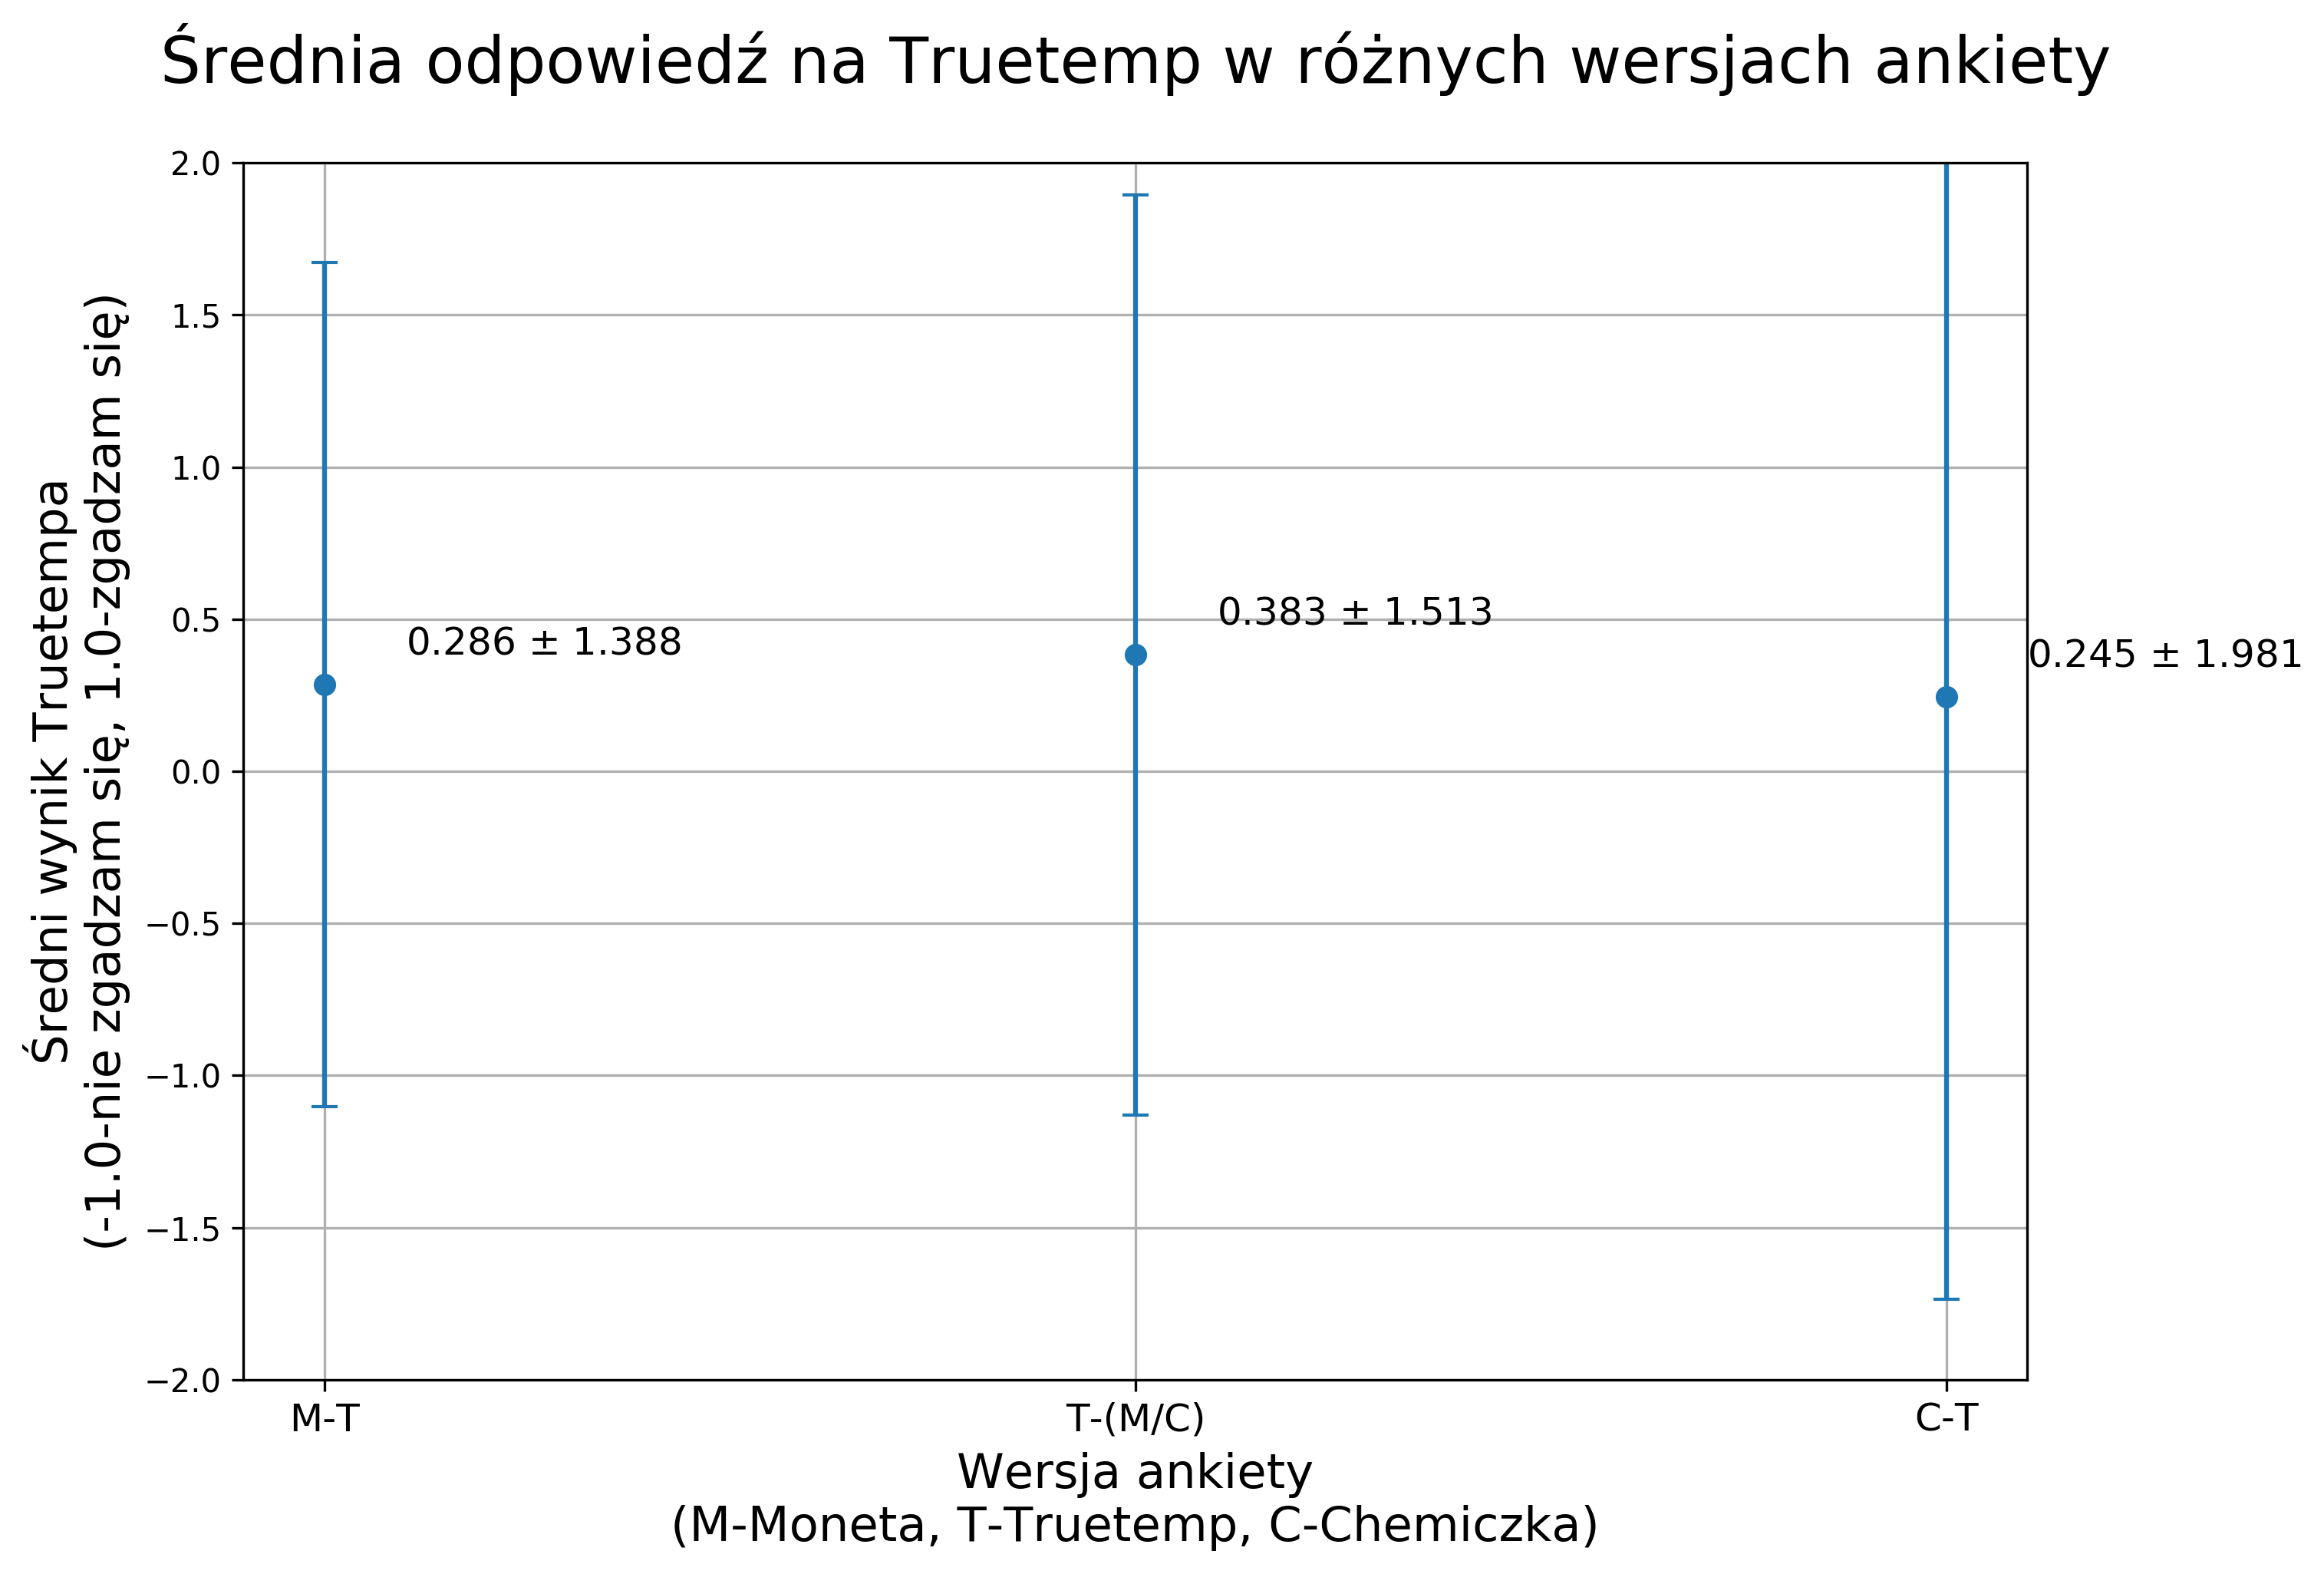

In [14]:
from visualize_data import plot_truetemp_dependence_on_preceding_story

plot_data = {'c': list(truetemp_data['{}-{}'.format(c, t)]),
             'none': list(truetemp_data['{}-{}'.format(t, ch)]) + list(truetemp_data['{}-{}'.format(t, c)]),
             'ch': list(truetemp_data['{}-{}'.format(ch, t)])}

plot_truetemp_dependence_on_preceding_story(plot_data, 'mean_truetemp_en.png')